# Pytorch implementation
---

### Imports

In [130]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torchvision.datasets as dataset

from torch.optim import lr_scheduler
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import os
import numpy as np
import pandas as pd
import math

In [131]:
from pdb import set_trace

### Resizing images

The original images were ~3000x3000. I have resized it to 300x300 for computational efficiency

In [132]:
sz = (300,300) #specify the final size

In [133]:
# fn1 = !ls data/normal
# fn2 = !ls data/condition

In [134]:
# for n in fn1:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/normal/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/normal/{n}',format='png')
    

In [135]:
# for n in fn2:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/condition/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/condition/{n}',format='png')

---

We have 800 X-ray images. We have split it into train (680 images) and validation (120 images). 15% validation

### Sample image

In [136]:
path = 'data/'

In [137]:
sample = plt.imread('data/montgomery_china_resized/train/normal/CHNCXR_0001_0.png')

In [138]:
sample.shape

(291, 300, 3)

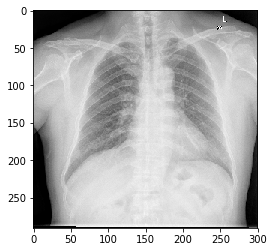

In [139]:
plt.imshow(sample)

---

### Transforms

Below are some few kind of transforms that are generally used for data augmentation

In [140]:
sample = Image.open('data/montgomery_china_resized/train/normal/CHNCXR_0001_0.png')

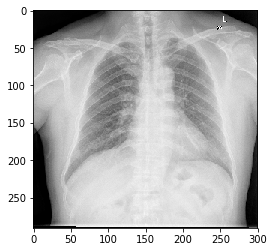

In [141]:
plt.imshow(sample) #actual image

#### Center Crop

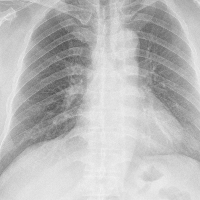

In [142]:
t = transforms.CenterCrop(200)
t(sample)

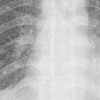

In [143]:
t = transforms.CenterCrop(100)
t(sample)

#### Random Crop

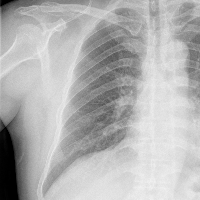

In [144]:
t = transforms.RandomCrop(200)
t(sample)

In [145]:
t(sample).size

(200, 200)

#### Horizontal Flip

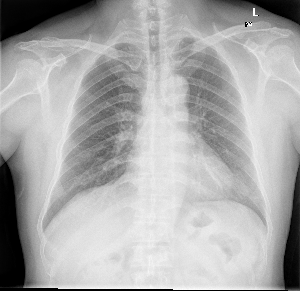

In [146]:
t = transforms.RandomHorizontalFlip()
t(sample)

#### Vertical Flip

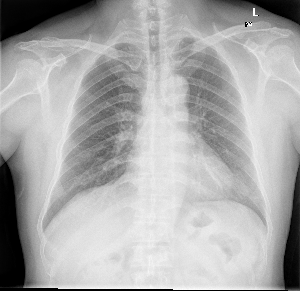

In [147]:
t = transforms.RandomVerticalFlip()

t(sample)

#### Rotation

In [148]:
t = transforms.RandomRotation((0,20))

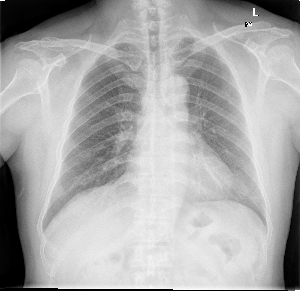

In [149]:
t(sample)

### Defining transforms for this dataset

In [150]:
# Specifying your transforms
transform = transforms.Compose([
# #     transforms.RandomCrop(224), #the output size should be less than the original size of the input image if using RandomCrop
    transforms.RandomResizedCrop(300), #using for variable size input images for now
#     transforms.Resize(224),
    transforms.ToTensor()
])

### Data Loader

In [151]:
batch_size = 64 #specify the mini batch size

This method of data loader is used if we have 2 folders train and validation and there are separate folders for each class within them

In [152]:
# def my_collate(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     target = torch.LongTensor(target)
#     return [data, target]

In [153]:
#for training
traindir = os.path.join('data/montgomery_china_resized/', 'train')
train = dataset.ImageFolder(traindir, transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=0)

In [154]:
#for validation
valdir = os.path.join('data/montgomery_china_resized/', 'valid')
valid = dataset.ImageFolder(valdir, transform)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False,num_workers=0)

In [155]:
%%time
xmb,ymb = (iter(train_loader)).next()

CPU times: user 356 ms, sys: 36 ms, total: 392 ms
Wall time: 277 ms


In [156]:
type(xmb)

torch.FloatTensor

In [157]:
xmb.size()

torch.Size([64, 3, 300, 300])

### Building your CNN network

In [198]:
# CNN Model (4 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU())
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU())
     
        self.fc1 = nn.Linear(75*75*64, 2)
#         self.fc2 = nn.Linear(10,2)
        self.sm = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
#         set_trace()
        out = self.layer1(x)
        out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
#         out = self.fc2(out)
        out = self.sm(out)
#       
        return out

### Initializing your network

In [199]:
cnn = CNN() #instantiating your CNN class
cnn.cuda() #shifting it to gpu
criterion = nn.NLLLoss()

### Training of the network

In [200]:
num_epochs = 6

In [201]:
optimizer = torch.optim.Adam(cnn.parameters(),lr =1e-3)

In [202]:
iterations = 0

In [203]:

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
#         set_trace()
#         images = Variable(images)
        images = Variable(images).cuda() #for gpu
#         labels = Variable(labels)
        labels = Variable(labels).cuda() #for gpu
        # Forward + Backward + Optimize
        optimizer.zero_grad() #putting all gradients to zero
        outputs = cnn(images) #forward pass
        loss = criterion(outputs, labels) #calculating loss
        loss.backward() #backward pass to calculate gradients
        optimizer.step() #updating the network parameters
        iterations+=1
        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.data[0]))
print(iterations)
print(loss.data[0])

Epoch [1/6], Iter [5/10] Loss: 0.7821
Epoch [1/6], Iter [10/10] Loss: 0.6824
Epoch [2/6], Iter [5/10] Loss: 0.6975
Epoch [2/6], Iter [10/10] Loss: 0.6957
Epoch [3/6], Iter [5/10] Loss: 0.6995
Epoch [3/6], Iter [10/10] Loss: 0.6711
Epoch [4/6], Iter [5/10] Loss: 0.7312
Epoch [4/6], Iter [10/10] Loss: 0.6528
Epoch [5/6], Iter [5/10] Loss: 0.7032
Epoch [5/6], Iter [10/10] Loss: 0.6592
Epoch [6/6], Iter [5/10] Loss: 0.6723
Epoch [6/6], Iter [10/10] Loss: 0.6726
66
0.7084789872169495


### Predicting on training set

In [191]:
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in train_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 640 training images: %d %%' % (100 * correct / total))

# Save the Trained Model
# torch.save(cnn.state_dict(), 'cnn.pkl')

Test Accuracy of the model on the 640 training images: 50 %


---

### Predicting on validation set

In [112]:
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in valid_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 120 validation images: %d %%' % (100 * correct / total))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')

Test Accuracy of the model on the 120 validation images: 59 %


---

### Finding optimum learning rate

In [83]:
def lr_finder(lr_start,lr_end,network,min_iterations):
    optimizer = torch.optim.Adam(network.parameters(), lr=lr_start) #defining your optimizer and learning rate from where you want to start
    iter_per_epoch = len(train)//batch_size
    num_epochs = math.ceil(min_iterations/iter_per_epoch)
    iter_total = num_epochs*iter_per_epoch
    
    growth_rate = (lr_end/lr_start)**(1/iter_total)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,gamma = growth_rate,step_size=1)
    
    l = []
    lr = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
    #         images = Variable(images)
            images = Variable(images).cuda() #for gpu
    #         labels = Variable(labels)
            labels = Variable(labels).cuda() #for gpu

            # Forward + Backward + Optimize
            lr.append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.optimizer.zero_grad() #putting all gradients to zero
            outputs = network(images) #forward pass
            loss = criterion(outputs, labels) #calculating loss
            l.append(loss.data[0])
            loss.backward() #backward pass to calculate gradients
            scheduler.step() #updating the network parameters
    
    plt.plot(lr, l)
    return lr,l
    
    

In [73]:
l1,l2 = lr_finder(1e-5,1e-1,cnn,150)

RuntimeError: size mismatch at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/generic/THCTensorMathBlas.cu:243

---

# Keras implementation

In [286]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow